# Stochastic volatility
This Notebook demos how to construct a stochastic volatility model and fit it to data. We will use the precision model of G. Chacko and L. M. Viceira. `Dynamic consumption and portfolio choice with stochastic volatility in incomplete markets` given by
\begin{cases}
\mathrm{d}Y_t = \left (\mu + \beta e^{-V_t} \right ) \mathrm{d}t + e^{-V_t/2} \mathrm{d}W_t, \\
\mathrm{d}V_t = \kappa \left (\gamma - V_t \right ) \mathrm{d}t + \sigma \mathrm{d}B_t, \\
\end{cases}
where $\mu, \beta, \gamma \in \mathbb{R}$, and $\kappa, \sigma \in \mathbb{R}_+$. $\{W_t\}$ and $\{V_t\}$ are two one-dimensional, assumed independent, Wiener processes. As the above model is defined in continuous time, we need to discretize it; we do so using the Euler-Maruyma scheme.

We begin with importing the necessary libraries for defining the model.

In [1]:
from pyfilter.timeseries import StateSpaceModel, EulerMaruyma, Observable

Next, we define the governing dynamics. We assume that the initial distribution of the model is given by 
\begin{equation}
V_0 \sim \mathcal{N} \left ( \gamma, \frac{\sigma}{\sqrt{2 \kappa}} \right ),
\end{equation}
so that we get the following functions

In [2]:
import torch

def fh0(reversion, level, std):
    return level


def gh0(reversion, level, std):
    return std # / np.sqrt(2 * reversion)


def fh(x, reversion, level, std):
    return reversion * (level - x)


def gh(x, reversion, level, std):
    return std


def go(vol, level, beta):
    return level + beta * torch.exp(-vol) / 2


def fo(vol, level, beta):
    return torch.exp(-vol / 2)

Next, we shall define our model. In order to do so, we must specify priors for the different parameters. Given their support, we assume that
\begin{cases}
    \mu, \gamma \sim \mathcal{N}(0, 1), \\
    \kappa, \sim \mathcal{B}(1, 5), \\
    \sigma \sim \mathcal{IG}(2)
\end{cases}
and for simplicity that $\beta \triangleq 0$. To do this, we need to import the necessary distributions.

In [3]:
from torch.distributions import Exponential, Normal

Next, we define the model in terms of code and get

In [4]:
volparams = Exponential(5), Normal(0., 1.), Exponential(5)
logvol = EulerMaruyma((fh0, gh0), (fh, gh), volparams, (Normal(0., 1.), Normal(0., 1.)))
obs = Observable((go, fo), (Normal(0., 1.), 0.), Normal(0., 1.))

stockmodel = StateSpaceModel(logvol, obs)

And that defines the model. Next, we need a dataset to train on. We're just going to pick one of the stocks represented in the S&P500, and that is Conoco Phillips (`COP`). We load the data using Quandl and get, starting from 2010 and onwards

In [5]:
import quandl
import numpy as np

stock = 'AAPl'
y = np.log(quandl.get('WIKI/{:s}'.format(stock), start_date='2010-01-01', column_index=11, api_key='p3_zcQvXHZb2EbrsmoyZ', transform='rdiff') + 1)
y *= 100

We plot the data to get an idea of its volatility

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 9))

y.plot(ax=ax)

From the above plot we clearly see that Conoco Phillips is volatile for the majority of the period, but clear a volatility cluster at the beginning of 2016. In order to fit the model to the given data, we need an algorithm. We shall use a combination of NESS and SMC$^2$. We use SMC$^2$ for the first part of the data set, and then switch to NESS. Furthermore, since we are using particle filters, we need to decide on which proposal to use - should we go with the Bootstrap or something more advanced? For this example, we will use a linearized version. Importing the relevant classes, we get

In [14]:
from pyfilter.algorithms import NESSMC2
from pyfilter.filters import SISR

Let us now fit the model to the data, and time the process!

In [ ]:
import time
predictions = 10
start = time.time()

algs = list()
training = torch.tensor(y.iloc[:-predictions].values, dtype=torch.float32)

for i in range(4):
    filt = SISR(stockmodel.copy(), 300)
    
    algs.append(
        NESSMC2(filt, 1000, handshake=500).initialize().fit(training)
    )
print('Took {:.0f} seconds on average to finish the filtering procedure for {:d} observations'.format((time.time() - start) / (i + 1), y.size))

NESSMC2:  15%|██████████▏                                                        | 314/2059 [05:01<16:17:04, 33.60s/it]

We plot the filtered volatility component and superimpose it on the returns to see if it correctly captures the observed behavior

TypeError: sum() received an invalid combination of arguments - got (axis=int, out=NoneType, ), but expected one of:
 * ()
 * (torch.dtype dtype)
 * (tuple of ints dim, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: axis, out
 * (tuple of ints dim, bool keepdim, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out


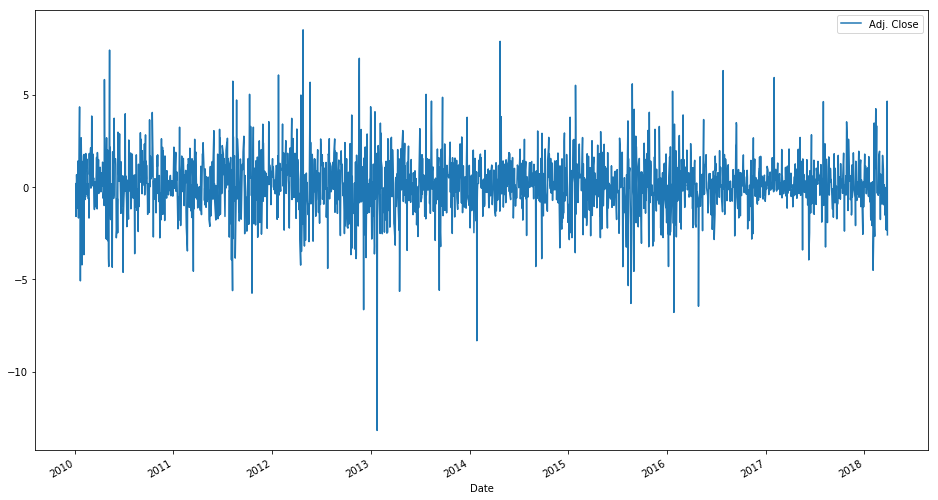

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
y.plot(ax=ax)

for i, alg in enumerate(algs):
    ax.plot(y.index[:-predictions], np.exp(-np.array(alg.filtermeans()) / 2), alpha=0.75, label='Filter {:d}'.format(i+1))

y.iloc[:-predictions].rolling(20).std().plot(ax=ax)
ax.legend()

We also plot the distribution of the residuals together with a normal distribution to see if it's a good fit

In [ ]:
import pandas as pd
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(16, 9))

for alg in algs:
    nm = pd.Series(alg.noisemeans())
    nm.plot.kde(ax=ax, label='Residuals')

x = np.linspace(nm.min() - 4, nm.max() + 4, 500)
ax.plot(x, norm.pdf(x), 'r', label='$\mathcal{N}(0, 1)$')
plt.legend()

A visual inspection suggests that this is indeed a good fit.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.acorr(alg.noisemeans(), maxlags=50)

plt.show()

Let's also plot the posterior distributions

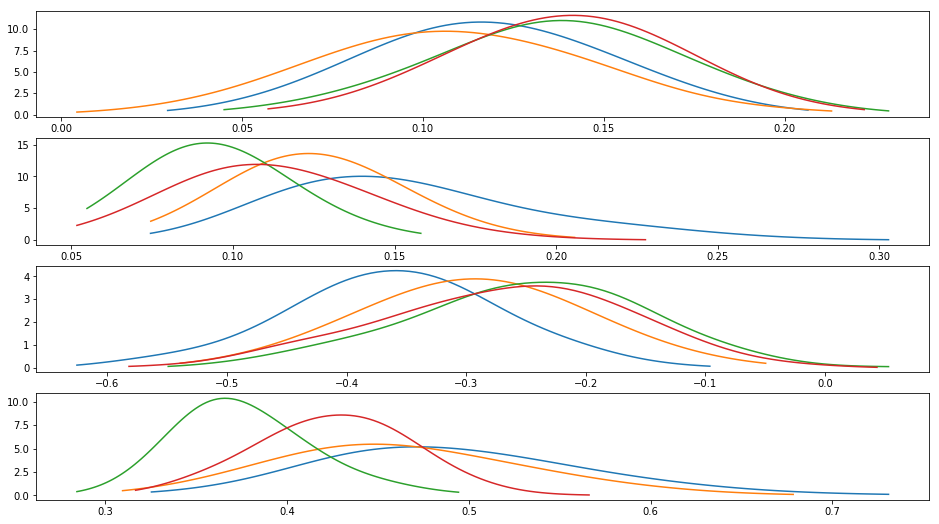

In [16]:
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
import numpy as np

fig, ax = plt.subplots(4, figsize=(16, 9))

for r, alg in enumerate(algs):
    param = alg.filter.ssm.observable.theta[0]
    
    plot_range = param.get_range().reshape(-1, 1)
    kde = param.get_kde(cv=2)
    
    ax[0].plot(plot_range, np.exp(kde.score_samples(plot_range)), label='Filter {:d}'.format(r+1))

    for i, param in enumerate(alg.filter.ssm.hidden.theta):
        plot_range = param.get_range().reshape(-1, 1)
        kde = param.get_kde(cv=2)
        
        ax[i+1].plot(plot_range, np.exp(kde.score_samples(plot_range)), label='Filter {:d}'.format(r+1))

Let's try and predict the future distributions of returns and superimpose the actual returns

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

actualreturns = y.iloc[-predictions:].cumsum().values
ax.plot(y.index[-predictions:], actualreturns, label='Actual returns')

for i, alg in enumerate(algs):
    px, py = alg.predict(predictions)

    cum_py = np.percentile(np.cumsum(py, axis=0), [1, 50, 99], axis=1).T

    ax.plot(y.index[-predictions:], cum_py, 'r', alpha=0.5)

plt.legend()